In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
# !cp drive/'My Drive'/radhakrishna.tar.gz /content
!cp drive/'My Drive'/groupemotion.zip /content

In [4]:
# !tar -xvzf radhakrishna.tar.gz
!unzip groupemotion.zip

Streaming output truncated to the last 5000 lines.
  inflating: groupemotion/Aligned/Positive/pos_3442.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3443.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3444.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3445.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3446.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3447.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3448.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3449.jpg  
  inflating: groupemotion/Aligned/Positive/pos_345 (2).jpg  
  inflating: groupemotion/Aligned/Positive/pos_345.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3450.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3451.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3452.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3453.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3454.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3455.jpg  
  inflating: groupe

In [5]:
!cd groupemotion/Aligned/ && ls

Negative  Neutral  Positive


In [6]:
pip install tflearn

     |████████████████████████████████| 112kB 9.9MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp36-none-any.whl size=127301 sha256=5fa705b91c6697d2184744f8450c445201a718e6efeb1d4d0f1ac2c8baaccf1b
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [7]:
#Importing necessary libraries
import tflearn
import numpy as np
from numpy import genfromtxt
from tflearn.data_preprocessing import ImagePreprocessing
import keras

Instructions for updating:
non-resource variables are not supported in the long term


In [8]:
# data
X = []
# labels
X_labels = []

# size of the image - 64x64
IMG_SIZE = 64

# assign variables for paths of each class
POSITIVE_DIR = 'groupemotion/Aligned/Positive/'
NEUTRAL_DIR = 'groupemotion/Aligned/Neutral/'
NEGATIVE_DIR = 'groupemotion/Aligned/Negative/'

In [9]:
def generate_data_from_images(emotion_type, directory):
  # tqdm used for progress bar
  # for each image in the specified directory
  for image in tqdm(os.listdir(directory)):
    filename = os.fsdecode(image)
    if filename.endswith(".jpg"): 
      # read the colored image
      image = cv2.imread(os.path.join(directory, image))
      # resize image to 64x64
      image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
      
      # append the image as a numpy array to X
      X.append(np.array(image))
      # append the label to Z
      X_labels.append(emotion_type)

In [10]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data Manipulation libraries
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import style
 
# Matplotlib configuration
%matplotlib inline  
style.use('fivethirtyeight')

# Keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import Dropout, Flatten, Activation, Reshape, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU
from keras.utils.data_utils import get_file
from tqdm import tqdm
import random
import os
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# Image manipulation libraries
import cv2                  
from PIL import Image
# Set seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [11]:
generate_data_from_images('Positive', POSITIVE_DIR)

100%|██████████| 5724/5724 [01:02<00:00, 92.15it/s]


In [12]:
generate_data_from_images('Neutral', NEUTRAL_DIR)

100%|██████████| 4448/4448 [00:50<00:00, 88.15it/s]


In [13]:
generate_data_from_images('Negative', NEGATIVE_DIR)

100%|██████████| 3989/3989 [00:45<00:00, 86.74it/s]


In [14]:
len(X), len(X_labels)

(14161, 14161)

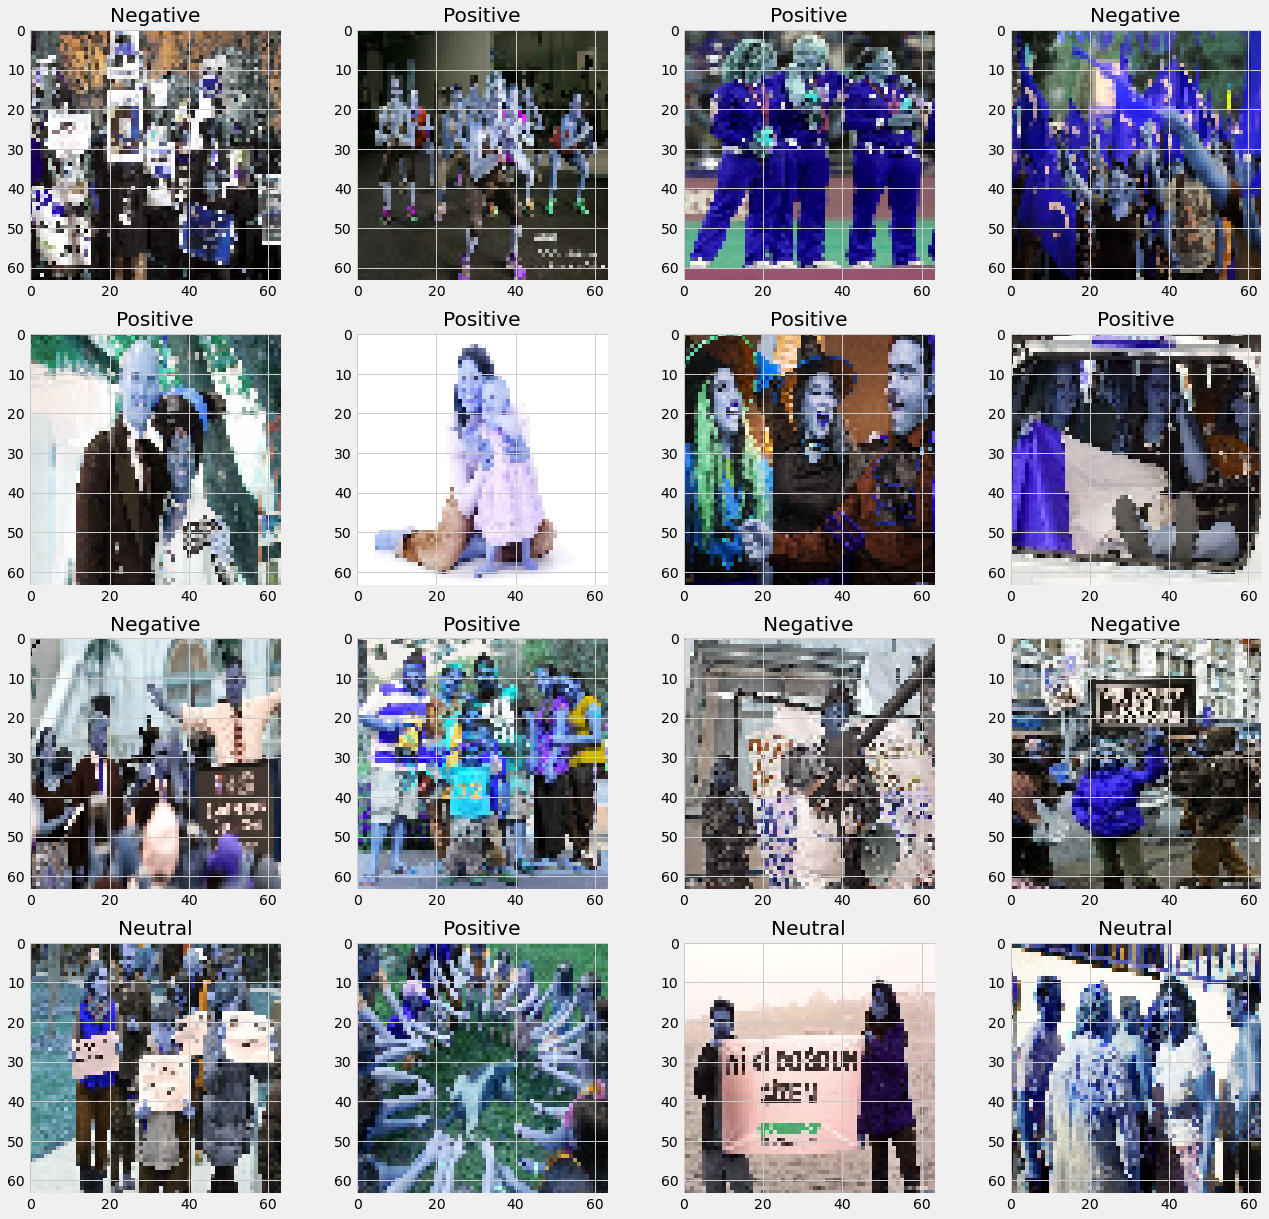

In [15]:
cols = 4
rows = 4
fig, axis = plt.subplots(rows, cols)
fig.set_size_inches(20, 20)
for i in range(rows):
  for j in range(cols):
    image_index = random.randint(0, len(X))
    axis[i, j].imshow(X[image_index])
    axis[i, j].set_title(X_labels[image_index])

In [16]:
# initialize the label encoder class
labelencoder = LabelEncoder()

# Convert the 3 classes "positive", "neutral" and "negative" into corresponding 
# numerical classes - 2, 1 and 0.
Y = labelencoder.fit_transform(X_labels)
# Check the classes applied by the Label Encoder
labelencoder_classes = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(labelencoder_classes)
# Apply one-hot encoding to convert the label encoded categorical data
# into multiple columns where each numerical class is replaced by 0 or 1
Y = to_categorical(Y,3)

# Convert X into a numpy array
X = np.array(X)
# Normalize all the pixel values for each image by diving by 255
X = X/25

{'Negative': 0, 'Neutral': 1, 'Positive': 2}


In [17]:
num_features = 64
num_labels = 3
batch_size = 64
epochs = 100
width, height = 64, 64
snapshot_step=20

#x = np.load('./fdataX.npy')
#y = np.load('./flabels.npy')

#x -= np.mean(x, axis=0)
#x /= np.std(x, axis=0)

#for xx in range(10):
#    plt.figure(xx)
#    plt.imshow(x[xx].reshape((48, 48)), interpolation='none', cmap='gray')
#plt.show()

#splitting into training, validation and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1,random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=41)

#saving the test samples to be used later
np.save('modXtest', X_test)
np.save('modytest', Y_test)

In [18]:
from tensorflow.keras import regularizers
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D
from keras.models import Sequential

In [19]:
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression


# Building 'VGG Network'
network = input_data(shape=[64, 64, 3])

network = conv_2d(network, 64, 3, activation='relu')
network = conv_2d(network, 64, 3, activation='relu')
network = max_pool_2d(network, 2, strides=2)

network = conv_2d(network, 128, 3, activation='relu')
network = conv_2d(network, 128, 3, activation='relu')
network = max_pool_2d(network, 2, strides=2)

network = conv_2d(network, 256, 3, activation='relu')
network = conv_2d(network, 256, 3, activation='relu')
network = conv_2d(network, 256, 3, activation='relu')
network = max_pool_2d(network, 2, strides=2)

network = conv_2d(network, 512, 3, activation='relu')
network = conv_2d(network, 512, 3, activation='relu')
network = conv_2d(network, 512, 3, activation='relu')
network = max_pool_2d(network, 2, strides=2)

network = conv_2d(network, 512, 3, activation='relu')
network = conv_2d(network, 512, 3, activation='relu')
network = conv_2d(network, 512, 3, activation='relu')
network = max_pool_2d(network, 2, strides=2)

network = fully_connected(network, 1024, activation='relu')
network = dropout(network, 0.5)
network = fully_connected(network, 1024, activation='relu')
network = dropout(network, 0.5)
network = fully_connected(network, 3, activation='softmax')

network = regression(network, optimizer='rmsprop',
                     loss='categorical_crossentropy',
                     learning_rate=0.0001)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
# Using DNN(Deep Neural Network) from tflearn
model = tflearn.DNN(network, checkpoint_path='model_vgg',
                    max_checkpoints=1, tensorboard_verbose=0)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
#training the model
model.fit(X_train, Y_train, n_epoch=100, shuffle=True,
          show_metric=True, batch_size=64, snapshot_step=20,
          snapshot_epoch=False, run_id='vgg_emotion')

Training Step: 17999  | total loss: 0.09543 | time: 16.066s
| RMSProp | epoch: 100 | loss: 0.09543 - acc: 0.9848 -- iter: 11456/11469
Training Step: 18000  | total loss: 0.09197 | time: 16.156s
| RMSProp | epoch: 100 | loss: 0.09197 - acc: 0.9816 -- iter: 11469/11469
--


In [23]:
#evaluating the testing score
score = model.evaluate(X_test, Y_test)
print('Test accuarcy: ', score)

Test accuarcy:  [0.49894142567312205]


In [24]:
#save the trained model
model.save('vgg19_emotion.tfl')

In [28]:

#Function to plot graph of the expressions of the custom images
def detect_emotion(emotions):
   objects = ('Negative', 'Neutral', 'Positive')
   y_pos = np.arange(len(objects))

   plt.bar(y_pos, emotions, align='center', alpha=0.5)
   plt.xticks(y_pos, objects)
   plt.ylabel('percentage')
   plt.title('emotion')

   plt.show()

In [29]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [32]:
img = image.load_img("ss.jpg", grayscale=True, target_size=(64, 64))

x = image.img_to_array(img)

x = x.flatten()
x = x.reshape([64, 64, 3])

emotion_prediction = model.predict(x)
detect_emotion(emotion_prediction[0])

x = np.array(x, 'float32')
x = x.reshape([64, 64]);

plt.gray()
plt.imshow(x)
plt.show()

ValueError: ignored